In [1]:
# Standard library imports
import os

# Third party imports
import ee
from dotenv import load_dotenv
import geopandas as gpd
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box
from osgeo import gdal

#Specify the path to the service account key file (found in .env)
load_dotenv()
key_path = os.getenv('GEE_AUTH_KEY_PATH')

# Define the correct scope for Earth Engine
SCOPES = ['https://www.googleapis.com/auth/earthengine']

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=SCOPES
)

# Initialize Earth Engine
ee.Initialize(credentials=credentials)
print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!


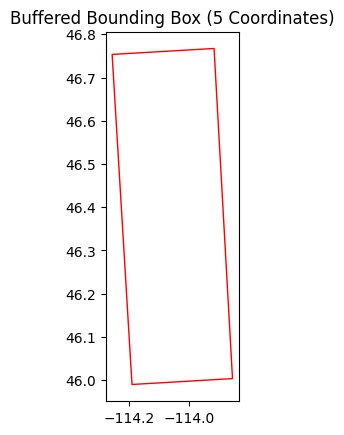

POLYGON ((-113.85331964647843 46.00330922727008, -113.91517682734853 46.767252207845296, -114.25706136644916 46.753479769892856, -114.19043659326701 45.98972965681367, -113.85331964647843 46.00330922727008))


In [29]:
# Read in GeoJSON files for each year and combine them
gdfs = []
years = [2008, 2009, 2012, 2016, 2019, 2020]
for year in years:
    gdf = gpd.read_file(f'data/vector/yearly_fold_assignments/{year}.geojson')
    gdfs.append(gdf)

# Combine into a single GeoDataFrame
roi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
roi.set_crs(gdfs[0].crs, inplace=True)

# Get the total bounds: (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = roi.total_bounds

buffer_amt = 1000  # Adjust this value as needed (in the same units as roi's CRS)

# Create a rectangle that is buffered by buffer_amt on all sides
# This will have exactly 5 coordinates: bottom-left, bottom-right, top-right, top-left, and bottom-left again.
buffered_rect = box(minx - buffer_amt, miny - buffer_amt, maxx + buffer_amt, maxy + buffer_amt)

# Convert to a GeoDataFrame and transform to EPSG:4326 if needed
buffered_bbox_gdf = gpd.GeoDataFrame({'geometry': [buffered_rect]}, crs=roi.crs)
buffered_bbox_gdf = buffered_bbox_gdf.to_crs("EPSG:4326")

# Plot the resulting rectangle
buffered_bbox_gdf.plot(edgecolor='red', facecolor='none')
plt.title("Buffered Bounding Box (5 Coordinates)")
plt.show()

# Print the coordinates
print(buffered_bbox_gdf.geometry.iloc[0])


In [32]:
# Convert all geometries to Earth Engine geometries
ee_geometries = []
for _, row in buffered_bbox_gdf.iterrows():
    coords = row.geometry.exterior.coords.xy
    ee_coords = [[x, y] for x, y in zip(coords[0], coords[1])]
    ee_geometries.append(ee.Geometry.Polygon(ee_coords, proj='EPSG:4326'))

# Create a GeometryCollection from the list of geometries
geometry_collection = ee.Geometry.MultiPolygon(ee_geometries)

# Get the bounding box of the GeometryCollection
bounding_box = geometry_collection.bounds()

# Image collection path
path_to_asset = 'projects/rap-data-365417/assets/vegetation-cover-v3'

# Load the image collection
image_collection = ee.ImageCollection(path_to_asset)

available_years = range(1986, 2024)

rap_dir = 'data/raster/rap' # Changed output directory to quadrants
os.makedirs(rap_dir, exist_ok=True)

# Set the GTIFF_SRS_SOURCE configuration option to EPSG
gdal.SetConfigOption('GTIFF_SRS_SOURCE', 'EPSG')

# Get bounding box coordinates
bbox_coords = bounding_box.getInfo()['coordinates'][0]
min_lon = min([coord[0] for coord in bbox_coords])
max_lon = max([coord[0] for coord in bbox_coords])
min_lat = min([coord[1] for coord in bbox_coords])
max_lat = max([coord[1] for coord in bbox_coords])

lat_range = max_lat - min_lat
lat_interval = lat_range / 4.0

for year in available_years:
    # Filter images for the specific year
    yearly_image = image_collection.filter(
        ee.Filter.calendarRange(year, year, 'year')
    ).median()

    for quad in range(4):
        quad_min_lat = min_lat + quad * lat_interval
        quad_max_lat = min_lat + (quad + 1) * lat_interval

        # Define quadrant bounding box
        quad_bbox = ee.Geometry.Rectangle(
            [min_lon, quad_min_lat, max_lon, quad_max_lat], proj='EPSG:4326'
        )
        clipped_image = yearly_image.clip(quad_bbox) # Clip to quadrant bbox

        url = clipped_image.getDownloadURL({
            'scale': 30,
            'crs': 'EPSG:6514',
            'region': quad_bbox, # Use quadrant bbox for region
            'format': 'GeoTIFF',
            'formatOptions': {
                'cloudOptimized': True,
                'noData': 255,
                'maxPixels': 1e9  # Increase maximum pixels allowed
            }
        })

        response = requests.get(url)

        # Create output file path with quadrant number
        output_file = os.path.join(rap_dir, f"{year}_{quad+1}.tif") # Quadrant numbers 1 to 4

        # Write response content directly to final file
        with open(output_file, 'wb') as f:
            f.write(response.content)

        print(f"Downloaded file {output_file}")

        # Set nodata value to 255 for all bands
        dataset = gdal.Open(output_file, gdal.GA_Update)
        if dataset: # Check if dataset is successfully opened
            for band_idx in range(1, dataset.RasterCount + 1):
                band = dataset.GetRasterBand(band_idx)
                band.SetNoDataValue(255)
            dataset = None
        else:
            print(f"Warning: Could not open {output_file} with GDAL for nodata setting.")

print("Finished downloading and processing in quadrants.")

Downloaded file data/raster/rap/1986_1.tif


Warning 1: data/raster/rap/1986_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1986_2.tif


Warning 1: data/raster/rap/1986_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1986_3.tif


Warning 1: data/raster/rap/1986_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1986_4.tif


Warning 1: data/raster/rap/1986_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1987_1.tif


Warning 1: data/raster/rap/1987_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1987_2.tif


Warning 1: data/raster/rap/1987_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1987_3.tif


Warning 1: data/raster/rap/1987_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1987_4.tif


Warning 1: data/raster/rap/1987_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1988_1.tif


Warning 1: data/raster/rap/1988_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1988_2.tif


Warning 1: data/raster/rap/1988_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1988_3.tif


Warning 1: data/raster/rap/1988_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1988_4.tif


Warning 1: data/raster/rap/1988_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1989_1.tif


Warning 1: data/raster/rap/1989_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1989_2.tif


Warning 1: data/raster/rap/1989_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1989_3.tif


Warning 1: data/raster/rap/1989_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1989_4.tif


Warning 1: data/raster/rap/1989_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1990_1.tif


Warning 1: data/raster/rap/1990_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1990_2.tif


Warning 1: data/raster/rap/1990_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1990_3.tif


Warning 1: data/raster/rap/1990_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1990_4.tif


Warning 1: data/raster/rap/1990_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1991_1.tif


Warning 1: data/raster/rap/1991_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1991_2.tif


Warning 1: data/raster/rap/1991_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1991_3.tif


Warning 1: data/raster/rap/1991_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1991_4.tif


Warning 1: data/raster/rap/1991_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1992_1.tif


Warning 1: data/raster/rap/1992_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1992_2.tif


Warning 1: data/raster/rap/1992_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1992_3.tif


Warning 1: data/raster/rap/1992_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1992_4.tif


Warning 1: data/raster/rap/1992_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1993_1.tif


Warning 1: data/raster/rap/1993_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1993_2.tif


Warning 1: data/raster/rap/1993_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1993_3.tif


Warning 1: data/raster/rap/1993_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1993_4.tif


Warning 1: data/raster/rap/1993_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1994_1.tif


Warning 1: data/raster/rap/1994_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1994_2.tif


Warning 1: data/raster/rap/1994_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1994_3.tif


Warning 1: data/raster/rap/1994_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1994_4.tif


Warning 1: data/raster/rap/1994_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1995_1.tif


Warning 1: data/raster/rap/1995_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1995_2.tif


Warning 1: data/raster/rap/1995_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1995_3.tif


Warning 1: data/raster/rap/1995_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1995_4.tif


Warning 1: data/raster/rap/1995_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1996_1.tif


Warning 1: data/raster/rap/1996_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1996_2.tif


Warning 1: data/raster/rap/1996_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1996_3.tif


Warning 1: data/raster/rap/1996_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1996_4.tif


Warning 1: data/raster/rap/1996_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1997_1.tif


Warning 1: data/raster/rap/1997_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1997_2.tif


Warning 1: data/raster/rap/1997_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1997_3.tif


Warning 1: data/raster/rap/1997_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1997_4.tif


Warning 1: data/raster/rap/1997_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1998_1.tif


Warning 1: data/raster/rap/1998_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1998_2.tif


Warning 1: data/raster/rap/1998_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1998_3.tif


Warning 1: data/raster/rap/1998_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1998_4.tif


Warning 1: data/raster/rap/1998_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1999_1.tif


Warning 1: data/raster/rap/1999_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1999_2.tif


Warning 1: data/raster/rap/1999_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1999_3.tif


Warning 1: data/raster/rap/1999_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/1999_4.tif


Warning 1: data/raster/rap/1999_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2000_1.tif


Warning 1: data/raster/rap/2000_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2000_2.tif


Warning 1: data/raster/rap/2000_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2000_3.tif


Warning 1: data/raster/rap/2000_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2000_4.tif


Warning 1: data/raster/rap/2000_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2001_1.tif


Warning 1: data/raster/rap/2001_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2001_2.tif


Warning 1: data/raster/rap/2001_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2001_3.tif


Warning 1: data/raster/rap/2001_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2001_4.tif


Warning 1: data/raster/rap/2001_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2002_1.tif


Warning 1: data/raster/rap/2002_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2002_2.tif


Warning 1: data/raster/rap/2002_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2002_3.tif


Warning 1: data/raster/rap/2002_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2002_4.tif


Warning 1: data/raster/rap/2002_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2003_1.tif


Warning 1: data/raster/rap/2003_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2003_2.tif


Warning 1: data/raster/rap/2003_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2003_3.tif


Warning 1: data/raster/rap/2003_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2003_4.tif


Warning 1: data/raster/rap/2003_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2004_1.tif


Warning 1: data/raster/rap/2004_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2004_2.tif


Warning 1: data/raster/rap/2004_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2004_3.tif


Warning 1: data/raster/rap/2004_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2004_4.tif


Warning 1: data/raster/rap/2004_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2005_1.tif


Warning 1: data/raster/rap/2005_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2005_2.tif


Warning 1: data/raster/rap/2005_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2005_3.tif


Warning 1: data/raster/rap/2005_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2005_4.tif


Warning 1: data/raster/rap/2005_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2006_1.tif


Warning 1: data/raster/rap/2006_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2006_2.tif


Warning 1: data/raster/rap/2006_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2006_3.tif


Warning 1: data/raster/rap/2006_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2006_4.tif


Warning 1: data/raster/rap/2006_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2007_1.tif


Warning 1: data/raster/rap/2007_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2007_2.tif


Warning 1: data/raster/rap/2007_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2007_3.tif


Warning 1: data/raster/rap/2007_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2007_4.tif


Warning 1: data/raster/rap/2007_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2008_1.tif


Warning 1: data/raster/rap/2008_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2008_2.tif


Warning 1: data/raster/rap/2008_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2008_3.tif


Warning 1: data/raster/rap/2008_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2008_4.tif


Warning 1: data/raster/rap/2008_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2009_1.tif


Warning 1: data/raster/rap/2009_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2009_2.tif


Warning 1: data/raster/rap/2009_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2009_3.tif


Warning 1: data/raster/rap/2009_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2009_4.tif


Warning 1: data/raster/rap/2009_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2010_1.tif


Warning 1: data/raster/rap/2010_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2010_2.tif


Warning 1: data/raster/rap/2010_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2010_3.tif


Warning 1: data/raster/rap/2010_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2010_4.tif


Warning 1: data/raster/rap/2010_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2011_1.tif


Warning 1: data/raster/rap/2011_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2011_2.tif


Warning 1: data/raster/rap/2011_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2011_3.tif


Warning 1: data/raster/rap/2011_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2011_4.tif


Warning 1: data/raster/rap/2011_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2012_1.tif


Warning 1: data/raster/rap/2012_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2012_2.tif


Warning 1: data/raster/rap/2012_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2012_3.tif


Warning 1: data/raster/rap/2012_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2012_4.tif


Warning 1: data/raster/rap/2012_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2013_1.tif


Warning 1: data/raster/rap/2013_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2013_2.tif


Warning 1: data/raster/rap/2013_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2013_3.tif


Warning 1: data/raster/rap/2013_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2013_4.tif


Warning 1: data/raster/rap/2013_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2014_1.tif


Warning 1: data/raster/rap/2014_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2014_2.tif


Warning 1: data/raster/rap/2014_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2014_3.tif


Warning 1: data/raster/rap/2014_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2014_4.tif


Warning 1: data/raster/rap/2014_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2015_1.tif


Warning 1: data/raster/rap/2015_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2015_2.tif


Warning 1: data/raster/rap/2015_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2015_3.tif


Warning 1: data/raster/rap/2015_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2015_4.tif


Warning 1: data/raster/rap/2015_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2016_1.tif


Warning 1: data/raster/rap/2016_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2016_2.tif


Warning 1: data/raster/rap/2016_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2016_3.tif


Warning 1: data/raster/rap/2016_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2016_4.tif


Warning 1: data/raster/rap/2016_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2017_1.tif


Warning 1: data/raster/rap/2017_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2017_2.tif


Warning 1: data/raster/rap/2017_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2017_3.tif


Warning 1: data/raster/rap/2017_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2017_4.tif


Warning 1: data/raster/rap/2017_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2018_1.tif


Warning 1: data/raster/rap/2018_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2018_2.tif


Warning 1: data/raster/rap/2018_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2018_3.tif


Warning 1: data/raster/rap/2018_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2018_4.tif


Warning 1: data/raster/rap/2018_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2019_1.tif


Warning 1: data/raster/rap/2019_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2019_2.tif


Warning 1: data/raster/rap/2019_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2019_3.tif


Warning 1: data/raster/rap/2019_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2019_4.tif


Warning 1: data/raster/rap/2019_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2020_1.tif


Warning 1: data/raster/rap/2020_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2020_2.tif


Warning 1: data/raster/rap/2020_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2020_3.tif


Warning 1: data/raster/rap/2020_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2020_4.tif


Warning 1: data/raster/rap/2020_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2021_1.tif


Warning 1: data/raster/rap/2021_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2021_2.tif


Warning 1: data/raster/rap/2021_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2021_3.tif


Warning 1: data/raster/rap/2021_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2021_4.tif


Warning 1: data/raster/rap/2021_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2022_1.tif


Warning 1: data/raster/rap/2022_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2022_2.tif


Warning 1: data/raster/rap/2022_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2022_3.tif


Warning 1: data/raster/rap/2022_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2022_4.tif


Warning 1: data/raster/rap/2022_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2023_1.tif


Warning 1: data/raster/rap/2023_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2023_2.tif


Warning 1: data/raster/rap/2023_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2023_3.tif


Warning 1: data/raster/rap/2023_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Downloaded file data/raster/rap/2023_4.tif
Finished downloading and processing in quadrants.


Warning 1: data/raster/rap/2023_4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFWriteDirectorySec:Creating TIFF with legacy Deflate codec identifier, COMPRESSION_ADOBE_DEFLATE is more widely supported
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [37]:
for yr in range(1986, 2024):
    vrt_path = os.path.join(rap_dir, f'{yr}.vrt')
    tif_path = vrt_path.replace('vrt', 'tif')
    !gdalbuildvrt {vrt_path} {rap_dir}/{yr}_*.tif
    !gdal_translate -ot Byte -a_nodata 255 {vrt_path} {tif_path}



0...10...20..Warning 1: data/raster/rap/1986_1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
.30...40...50Warning 1: data/raster/rap/1986_2.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
...60...70..Warning 1: data/raster/rap/1986_3.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum 

In [38]:
# Remove quadrant files and VRT files
for file in os.listdir(rap_dir):
    if '_' in file or file.endswith('.vrt'):
        file_path = os.path.join(rap_dir, file)
        os.remove(file_path)
        print(f"Removed {file_path}")

Removed data/raster/rap/2013_4.tif
Removed data/raster/rap/1987.vrt
Removed data/raster/rap/1993.vrt
Removed data/raster/rap/2015_2.tif
Removed data/raster/rap/1986_1.tif
Removed data/raster/rap/2015_3.tif
Removed data/raster/rap/2017_1.tif
Removed data/raster/rap/1992.vrt
Removed data/raster/rap/1986.vrt
Removed data/raster/rap/1990.vrt
Removed data/raster/rap/2017_3.tif
Removed data/raster/rap/1999_4.tif
Removed data/raster/rap/2015_1.tif
Removed data/raster/rap/2008_4.tif
Removed data/raster/rap/1986_3.tif
Removed data/raster/rap/1986_2.tif
Removed data/raster/rap/2017_2.tif
Removed data/raster/rap/2011_4.tif
Removed data/raster/rap/1991.vrt
Removed data/raster/rap/2013_2.tif
Removed data/raster/rap/1995.vrt
Removed data/raster/rap/1999_1.tif
Removed data/raster/rap/.DS_Store
Removed data/raster/rap/2015_4.tif
Removed data/raster/rap/2008_1.tif
Removed data/raster/rap/2011_1.tif
Removed data/raster/rap/1994.vrt
Removed data/raster/rap/2013_3.tif
Removed data/raster/rap/2013_1.tif
Re